In [1]:
!pip install opencv-python imgbeddings psycopg2-binary

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.8 MB/s eta 0:00:00
  Created wheel for imgbeddings: filename=imgbeddings-0.1.0-py3-none-any.whl size=9324 sha256=cdbe43b27dcc1e2e9bc19dc6f5b630eaa93f539667264fc3d86d5eabdc29780c
  Stored in directory: /root/.cache/pip/wheels/4e/c9/9c/5f94fd783ce863540e5999f4bc2afd1501ddaea942ee6413fc
Successfully built imgbeddings


Step 1: Face recognition
Detect the faces from the test-image picture and store them under the stored-faces folder

In [3]:
# importing the cv2 library
import cv2

# loading the haar case algorithm file into alg variable
alg = "/content/haarcascade_frontalface_default.xml"
# passing the algorithm to OpenCV
haar_cascade = cv2.CascadeClassifier(alg)
# loading the image path into file_name variable - replace <INSERT YOUR IMAGE NAME HERE> with the path to your image
file_name = "/content/AVG.webp"
# reading the image
img = cv2.imread(file_name, 0)
# creating a black and white version of the image
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# detecting the faces
faces = haar_cascade.detectMultiScale(
    gray_img, scaleFactor=1.05, minNeighbors=2, minSize=(100, 100)
)

i = 0
# for each face detected
for x, y, w, h in faces:
    # crop the image to select only the face
    cropped_image = img[y : y + h, x : x + w]
    # loading the target image path into target_file_name variable  - replace <INSERT YOUR TARGET IMAGE NAME HERE> with the path to your target image
    target_file_name = 'stored-faces/' + str(i) + '.jpg'
    cv2.imwrite(
        target_file_name,
        cropped_image,
    )
    i = i + 1;

Step 2: Embeddings Calculation
Calculate embeddings from the faces and pushing to PostgreSQL, you'll need to change the <SERVICE_URI> parameter with the PostgreSQL Service URI

In [4]:
# Importing necessary libraries
import os
import numpy as np
from PIL import Image
import psycopg2
from transformers import CLIPProcessor, CLIPModel
import torch

# Connecting to the database
conn = psycopg2.connect("postgres://avnadmin:om:.........Your connection link")

# Initialize the CLIP model and processor (from transformers)
model_name = "openai/clip-vit-base-patch32"  # You can use any other model for embeddings
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name)

# Loop through all files in "stored-faces" directory
for filename in os.listdir("stored-faces"):
    # Skip if it's a directory (e.g., .ipynb_checkpoints)
    file_path = os.path.join("stored-faces", filename)
    if os.path.isdir(file_path):
        continue

    # Open the image
    img = Image.open(file_path)

    # Preprocess the image and prepare it for the model
    inputs = processor(images=img, return_tensors="pt", padding=True)

    # Generate the image embeddings
    with torch.no_grad():
        image_embeddings = model.get_image_features(**inputs)

    # Convert the tensor embeddings to a list format (flatten the tensor)
    embedding = image_embeddings.squeeze().cpu().numpy()

    # Insert the image filename and its corresponding embedding into the database
    cur = conn.cursor()
    # Use ON CONFLICT to update the embedding if the picture already exists
    cur.execute("""
        INSERT INTO pictures (picture, embedding)
        VALUES (%s, %s)
        ON CONFLICT (picture)
        DO UPDATE SET embedding = EXCLUDED.embedding
    """, (filename, embedding.tolist()))
    print(f"Attempted to insert or update {filename} in the database")

# Commit changes to the database
conn.commit()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Attempted to insert or update 0.jpg in the database
Attempted to insert or update 3.jpg in the database
Attempted to insert or update 2.jpg in the database
Attempted to insert or update 4.jpg in the database
Attempted to insert or update 1.jpg in the database
Attempted to insert or update 5.jpg in the database


Step 3: Calculate embeddings on a new picture
Find the face and calculate the embeddings on the picture solo-image.png used for research

In [5]:
# loading the face image path into file_name variable
file_name = "/content/download (7).jpg"  # replace <INSERT YOUR FACE FILE NAME> with the path to your image

# opening the image
img = Image.open(file_name)

# Importing the necessary components for CLIP embedding extraction
from transformers import CLIPProcessor, CLIPModel
import torch

# Function to get embeddings using the CLIP model
def get_clip_embeddings(image):
    # Load pre-trained CLIP model and processor
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

    # Preprocess the image for CLIP
    inputs = processor(images=image, return_tensors="pt", padding=True)

    # Get the embeddings from the CLIP model
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)

    # Normalize the embeddings (L2 norm)
    embeddings = outputs / outputs.norm(p=2, dim=-1, keepdim=True)

    return embeddings.squeeze().cpu().numpy()  # Return the embedding as a numpy array

# calculating the embeddings using CLIP
embedding = get_clip_embeddings(img)

# embedding is now a numpy array containing the image embedding


Step 3: Find similar images by querying the Postgresql database using pgvector

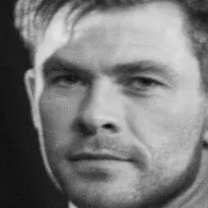

In [6]:
from IPython.display import Image, display

cur = conn.cursor()
string_representation = "[" + ",".join(str(x) for x in embedding.tolist()) + "]"
cur.execute("SELECT * FROM pictures ORDER BY embedding <-> %s LIMIT 1;", (string_representation,))
rows = cur.fetchall()
for row in rows:
    display(Image(filename="stored-faces/"+row[0]))
cur.close()